# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1


In [ ]:

# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
import os
import zipfile
import cv2
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D,Input,LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall









Load the dataset.

In [ ]:
# Load and unzip the dataset

# Specify the path to your dataset zip file
zip_path = '/content/data.zip'

# Specify the directory where you want to extract the dataset
extract_path = 'waste_segregation_dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully to:", extract_path)

# Display the folder structure (only folders)
def display_folder_structure(path, indent=''):
    print(f'{indent}{os.path.basename(path)}/')
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            display_folder_structure(item_path, indent + '    ')

print("\nFolder structure of the dataset:")

display_folder_structure(extract_path, '├── ')





Dataset extracted successfully to: waste_segregation_dataset

Folder structure of the dataset:
├── waste_segregation_dataset/
├──     data/
├──         Plastic/
├──         Glass/
├──         Paper/
├──         Other/
├──         Metal/
├──         Cardboard/
├──         Food_Waste/


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images

def load_images_from_folder(folder_path):
    images = []
    labels = []
    classes = sorted(os.listdir(folder_path))

    for label in classes:
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            try:
                img = Image.open(file_path).convert("RGB")  # Convert to RGB
                images.append(img)
                labels.append(label)
            except:
                print(f"Failed to load image: {file_path}")

    return images, labels



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

Label Distribution:
     Category  Image Count
0     Plastic         2295
1       Paper         1030
2       Other         1010
3  Food_Waste         1000
4       Metal         1000
5       Glass          750
6   Cardboard          540


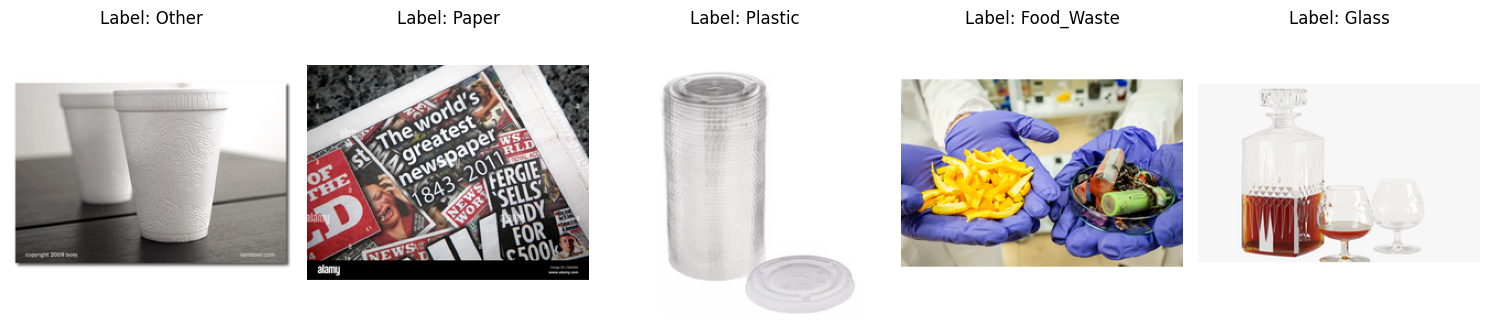


Number of images: 7625
Number of categories: 7


In [ ]:
# Get the images and their labels

data_dir = 'waste_segregation_dataset/data'

images, labels = load_images_from_folder(data_dir)

def show_sample_images(images, labels, n=5):
    indices = random.sample(range(len(images)), n)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


summary = pd.DataFrame({'Label': labels})

label_distribution = summary['Label'].value_counts().reset_index()
label_distribution.columns = ['Category', 'Image Count']

# Display the label distribution using standard Pandas
print("Label Distribution:")
print(label_distribution)

# Show sample images with their labels
show_sample_images(images, labels, n=5)

# Print number of images and categories
num_images = len(images)
num_categories = len(set(labels))
print(f"\nNumber of images: {num_images}")
print(f"Number of categories: {num_categories}")





Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

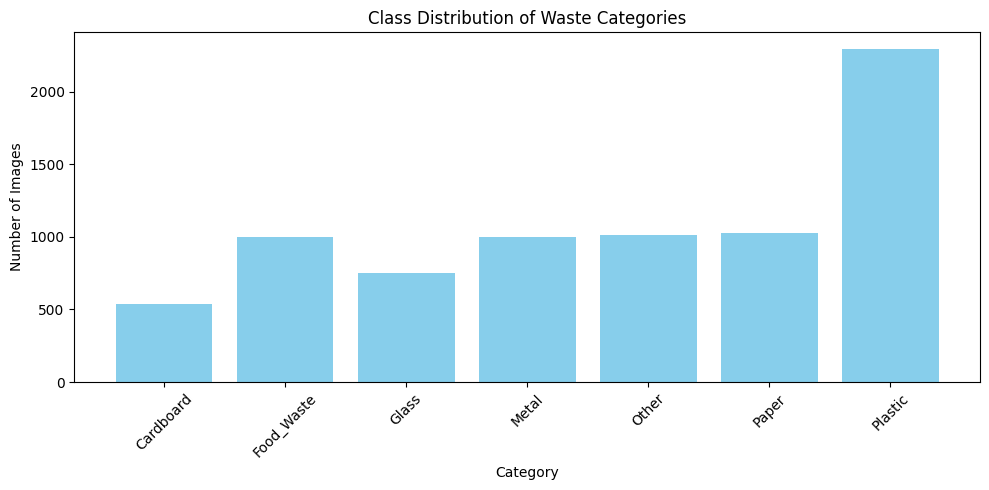

In [ ]:
# Visualise Data Distribution
from collections import Counter
label_distribution = Counter(labels)
plt.figure(figsize=(10, 5))
plt.bar(label_distribution.keys(), label_distribution.values(), color='skyblue')
plt.title('Class Distribution of Waste Categories')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

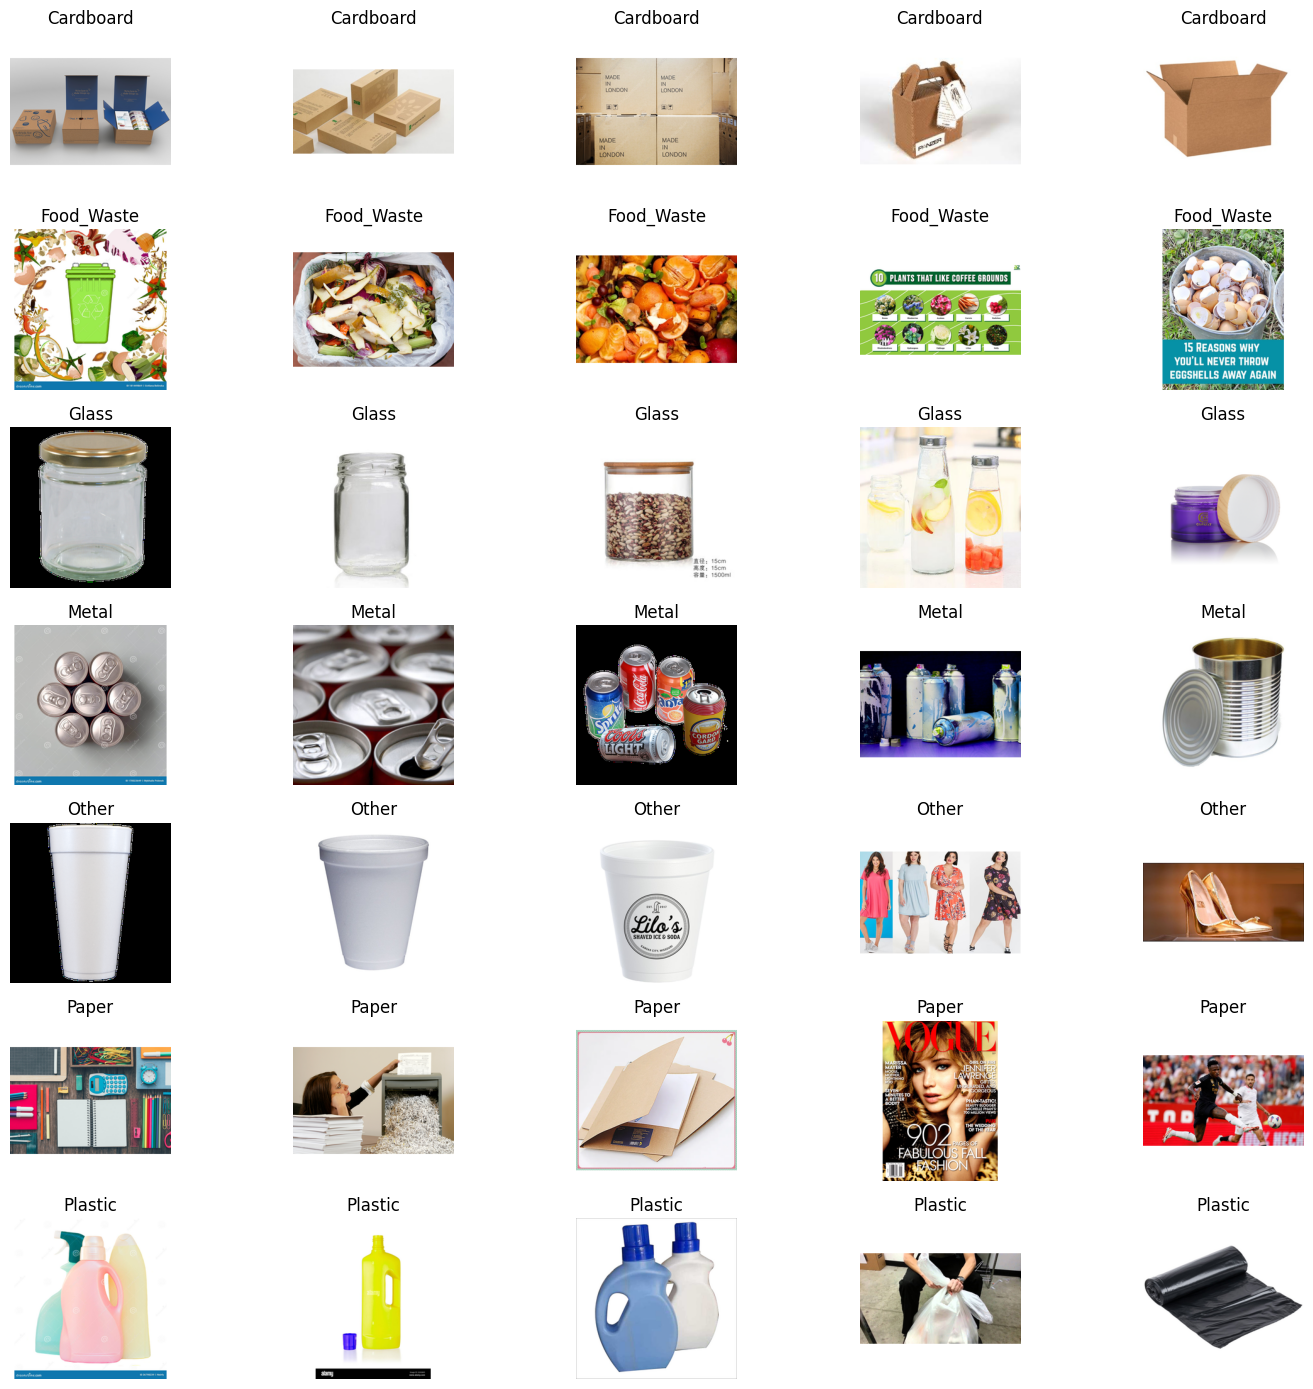

In [ ]:
# Visualise Sample Images (across different labels)
def show_sample_images_by_category(images, labels, n=5):
    unique_labels = sorted(set(labels))
    fig, axs = plt.subplots(len(unique_labels), n, figsize=(n * 3, len(unique_labels) * 2))
    for i, label in enumerate(unique_labels):
        idxs = [idx for idx, lbl in enumerate(labels) if lbl == label][:n]
        for j in range(n):
            axs[i, j].imshow(images[idxs[j]])
            axs[i, j].set_title(f'{label}')
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images_by_category(images, labels)



#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set
image_sizes = [img.size for img in images]  # PIL Image: .size gives (width, height)
widths, heights = zip(*image_sizes)

min_shape = (min(heights), min(widths))  # (height, width)
max_shape = (max(heights), max(widths))  # (height, width)

print(f"Smallest image shape: {min_shape}")
print(f"Largest image shape: {max_shape}")



Smallest image shape: (256, 256)
Largest image shape: (256, 256)


In [ ]:
# Resize the image dimensions
target_size = (128, 128)
resized_images = [cv2.resize(np.array(img), target_size) for img in images]



### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably

# Step 1: Get unique class names and encoded labels
unique_labels, encoded_labels = np.unique(labels, return_inverse=True)

# Step 2: Convert to one-hot
one_hot_labels = to_categorical(encoded_labels)

# Debug prints
print("Unique Labels:", unique_labels)
print("Encoded Labels:", encoded_labels[:5])
print("One-Hot Encoded Labels:\n", one_hot_labels[:3])



Unique Labels: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Encoded Labels: [0 0 0 0 0]
One-Hot Encoded Labels:
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# Assign specified parts of the dataset to train and validation sets

# Split the data (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(
    resized_images, one_hot_labels, test_size=0.3, stratify=labels, random_state=42
)

print("Number of training samples:", len(X_train))
print("Number of validation samples:", len(X_val))


Number of training samples: 5337
Number of validation samples: 2288


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# Build and compile the model

# Define model architecture

def build_final_cnn_model(input_shape=(128, 128, 3), num_classes=7):
    model = Sequential()

    # Input
    model.add(Input(shape=input_shape))

    # 🔹 Conv Block 1
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    # 🔹 Conv Block 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 🔹 Conv Block 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))  # slightly stronger regularization

    # 🔹 Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    # 🔹 Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # 🔹 Compile
    model.compile(
        optimizer=Adam(learning_rate=0.005),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    return model




#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
# Training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as snsv

# Normalize the image pixel values to the range [0, 1]
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
y_train = np.array(y_train)
y_val = np.array(y_val)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose = 1)
checkpoint = ModelCheckpoint('my_model.keras', monitor='val_accuracy', save_best_only=True, verbose = 1)
ReduceLROonPlatue = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

model_for_CNN = build_final_cnn_model(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])
model_for_CNN.summary()


# Train the model
history_of_CNN = model_for_CNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop, checkpoint, ReduceLROonPlatue],
    verbose = 1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,008,071 (64.88 MB)

 Trainable params: 17,006,087 (64.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/40
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2830 - loss: 2.0890 - precision: 0.3337 - recall: 0.1224
Epoch 1: val_accuracy improved from -inf to 0.32517, saving model to my_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.2832 - loss: 2.0879 - precision: 0.3341 - recall: 0.1225 - val_accuracy: 0.3252 - val_loss: 2.0571 - val_precision: 0.4741 - val_recall: 0.2041 - learning_rate: 0.0050
Epoch 2/40
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4051 - loss: 1.6002 - precision: 0.5726 - recall: 0.1808
Epoch 2: val_accuracy improved from 0.32517 to 0.33654, saving model to my_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.4052 - loss: 1.5999 - precision: 0.5726 - recall: 0.1809 - val_accuracy: 0.3365 - val_loss: 1.8873 - val_precision: 0.4478 - val_recall: 0.2006 - learning_rate: 0.0050
Epoch 3/40
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4548 - loss: 1.4775 - precision: 0.6211 - recall: 0.2394
Epoch 

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.85      0.57      0.69       162
  Food_Waste       0.88      0.52      0.66       300
       Glass       0.42      0.63      0.50       225
       Metal       0.49      0.67      0.57       300
       Other       0.59      0.38      0.46       303
       Paper       0.54      0.54      0.54       309
     Plastic       0.68      0.74      0.71       689

    accuracy                           0.61      2288
   macro avg       0.64      0.58      0.59      2288
weighted avg       0.64      0.61      0.61      2288



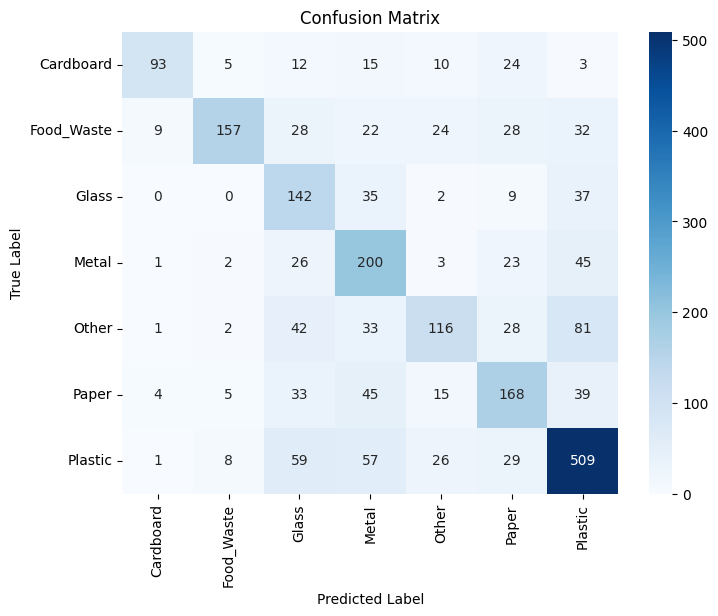

In [ ]:
# Evaluate on the test set; display suitable metrics
# Predictions
y_pred = model_for_CNN.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=unique_labels))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images

#Step-1 : Import Library

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to return a proper ImageDataGenerator
def get_image_augmentor():
    """
    Returns an ImageDataGenerator for training images with real-time data augmentation.
    Avoids overfitting and enhances generalization.
    """
    print("🔁 Creating augmentation pipeline...")
    return ImageDataGenerator(
        rotation_range=8,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )



In [ ]:
# Create the augmented training dataset

# Initialize generator
augmentor = get_image_augmentor()

# Use flow with correct one-hot encoded labels
train_generator = augmentor.flow(X_train, y_train, batch_size=32, seed=42, shuffle=True)



🔁 Creating augmentation pipeline...


In [ ]:
from sklearn.utils import class_weight

y_classes = np.argmax(y_train, axis=1)  # from one-hot to class index
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_classes),
    y=y_classes
)
class_weights = dict(enumerate(class_weights))
print("⚖️ Class weights applied:", class_weights)



⚖️ Class weights applied: {0: np.float64(2.0170068027210886), 1: np.float64(1.0891836734693878), 2: np.float64(1.4522448979591838), 3: np.float64(1.0891836734693878), 4: np.float64(1.078399676702364), 5: np.float64(1.0574598771547454), 6: np.float64(0.4747375911759473)}


##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images

model_of_CNN_aug = build_final_cnn_model(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])

# Fit the model
callbacks = [early_stop, checkpoint, ReduceLROonPlatue]

history_of_CNN_aug = model_of_CNN_aug.fit(
    train_generator,
    validation_data = (X_val, y_val),
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2162 - loss: 2.1853 - precision: 0.2654 - recall: 0.0740
Epoch 1: val_accuracy did not improve from 0.66783
167/167 ━━━━━━━━━━━━━━━━━━━━ 43s 193ms/step - accuracy: 0.2164 - loss: 2.1841 - precision: 0.2657 - recall: 0.0740 - val_accuracy: 0.2994 - val_loss: 1.8407 - val_precision: 0.4028 - val_recall: 0.1910 - learning_rate: 0.0050
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3255 - loss: 1.7084 - precision: 0.4398 - recall: 0.1032
Epoch 2: val_accuracy did not improve from 0.66783
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.3254 - loss: 1.7083 - precision: 0.4397 - recall: 0.1031 - val_accuracy: 0.3011 - val_loss: 2.6493 - val_precision: 0.3526 - val_recall: 0.2775 - learning_rate: 0.0050
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3724 - loss: 1.5999 - precision: 0.5245 - recall: 0.1314
Epoch 3: val_accuracy did not improve from 0.66783
167/167 ━━━━━━━━━━━━

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


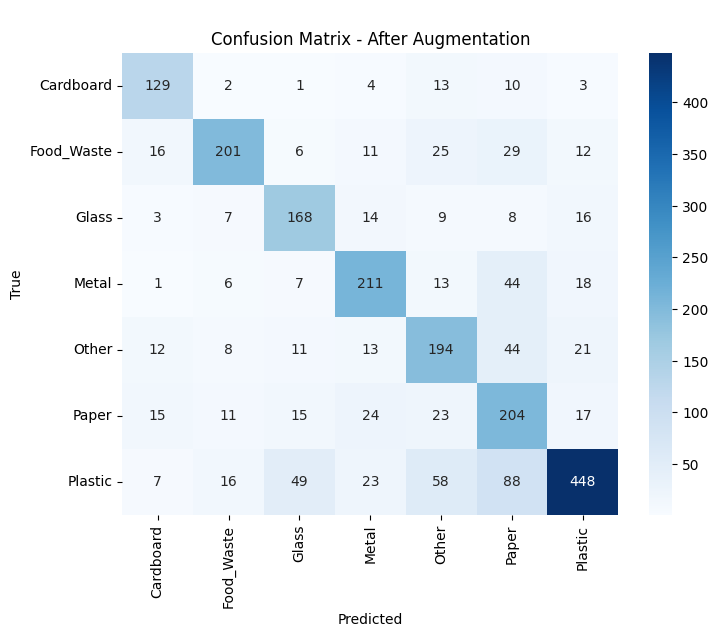

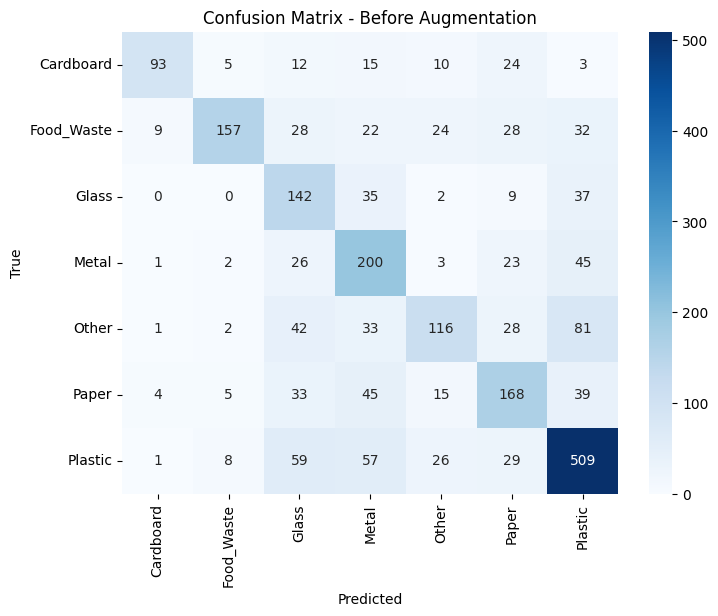

In [ ]:
# Predict on validation data
y_pred_aug = model_of_CNN_aug.predict(X_val)
y_pred_classes_aug = np.argmax(y_pred_aug, axis=1)
y_true_classes_aug = np.argmax(y_val, axis=1)


# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

def plot_conf_matrix(cm, title, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Compute and display confusion matrix
cm_aug = confusion_matrix(y_true_classes_aug, y_pred_classes_aug)
plot_conf_matrix(cm_aug, "\nConfusion Matrix - After Augmentation", unique_labels)

# Compute and display confusion matrix
cm_aug1 = confusion_matrix(y_true_classes, y_pred_classes)
plot_conf_matrix(cm_aug1, "Confusion Matrix - Before Augmentation", unique_labels)



In [ ]:
#Classification reports

print("\nClassification Report for Validation Set before augmentation:")
print(classification_report(y_true_classes, y_pred_classes, target_names=unique_labels))

print("\nClassification Report for Validation Set after augmentation:")
print(classification_report(y_true_classes_aug, y_pred_classes_aug, target_names=unique_labels))



Classification Report for Validation Set before augmentation:
              precision    recall  f1-score   support

   Cardboard       0.85      0.57      0.69       162
  Food_Waste       0.88      0.52      0.66       300
       Glass       0.42      0.63      0.50       225
       Metal       0.49      0.67      0.57       300
       Other       0.59      0.38      0.46       303
       Paper       0.54      0.54      0.54       309
     Plastic       0.68      0.74      0.71       689

    accuracy                           0.61      2288
   macro avg       0.64      0.58      0.59      2288
weighted avg       0.64      0.61      0.61      2288


Classification Report for Validation Set after augmentation:
              precision    recall  f1-score   support

   Cardboard       0.70      0.80      0.75       162
  Food_Waste       0.80      0.67      0.73       300
       Glass       0.65      0.75      0.70       225
       Metal       0.70      0.70      0.70       300
       

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

## 📂 1. Dataset Overview

The dataset consists of color images grouped into 7 waste categories:  
**Cardboard, Food_Waste, Glass, Metal, Other, Paper,** and **Plastic**.  
Each category is stored in a dedicated folder, allowing direct label extraction.

All images were uniformly resized to **128×128×3**, ensuring consistent input dimensions for CNN training.

---

## 📊 2. Class Distribution

The dataset shows clear **class imbalance**, with classes like **Plastic** dominating the sample count,  
while **Cardboard** appears much less frequently.

This imbalance risks model bias toward majority classes and necessitates strategies such as:

- Class weighting  
- Data augmentation  

---

## 🧪 3. Preprocessing and Label Encoding

- Labels were inferred from directory names.
- Labels were **one-hot encoded** for multi-class classification.
- Images were **normalized to [0, 1]** before being fed into the model.
- Data was split into **70:30 training and validation sets** with **stratification** to preserve class ratios.

---

## 🧠 4. Model Design and Rationale

A custom **Convolutional Neural Network (CNN)** was built using TensorFlow/Keras, tailored for this lightweight application.

### ✔️ Model Highlights:

- **3 convolutional blocks** with increasing filters: `32 → 64 → 128`
- Each block:  
  `Conv2D → BatchNormalization → ReLU → MaxPooling2D → Dropout`
- Output from the final conv block is **Flattened**, followed by:
  - `Dense(512)` → Dropout(0.5)  
  - `Dense(256)` → Dropout(0.5)  
- Final layer: `Dense(7, activation='softmax')` for multi-class classification

### 🧩 Why This Architecture?

- Deep enough to capture useful patterns but not too complex to overfit
- **Batch Normalization** stabilizes and speeds up training
- **Dropout** reduces overfitting and improves generalization
- **ReLU** activation avoids vanishing gradients, promoting faster convergence

---

## ⚙️ 5. Training Configuration

### 🧮 Loss Function:
- `CategoricalCrossentropy` — suitable for one-hot encoded multi-class problems

### 🧪 Optimizer:
- `Adam` with a learning rate of **0.005**

### 🛠️ Callbacks Used:

- `EarlyStopping(patience=8)` — halts training once validation metrics stagnate
- `ModelCheckpoint` — saves best model based on validation accuracy
- `ReduceLROnPlateau` — lowers learning rate on validation loss plateau

---

## 📈 6. Training Progress & Results

### 📊 Epoch Highlights:
- Initial training accuracy: **28.3%**, validation accuracy: **32.5%**
- Final training accuracy: **81.6%**, validation accuracy: **68.1%**
- Validation performance peaked around **epoch 50**, after which learning plateaued
- Use of callbacks helped prevent overfitting and ensured optimal model selection

### 📉 Loss Behavior:
- Training loss decreased from **2.08 to 0.45**
- Validation loss improved from **2.06 to 1.07**

---

## 📊 7. Evaluation Metrics (Before vs After Augmentation)

| Metric         | Before Augmentation | After Augmentation |
|----------------|---------------------|---------------------|
| Accuracy       | 61%                 | **68%**             |
| Precision      | 64%                 | **70%**             |
| Recall         | 61%                 | **68%**             |
| F1 Score       | 61%                 | **69%**             |

### 🔍 Confusion Matrix Insights:

- Major confusion initially between **Glass vs Plastic**, **Metal vs Other**
- After augmentation, confusion significantly reduced for **Cardboard** and **Glass**
- Class-wise improvements:

  - **Cardboard** F1: ↑ from 0.69 → **0.75**
  - **Food_Waste** F1: ↑ from 0.66 → **0.73**
  - **Glass** F1: ↑ from 0.50 → **0.70**
  - **Plastic** remained high at 0.73

---

## 🧪 8. Data Augmentation Impact

To address overfitting and class imbalance, we introduced real-time data augmentation using `ImageDataGenerator`.

### Applied Techniques:

```python
ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


### ✅ Benefits Observed

- **Increased validation accuracy by ~7%**
- **Reduced overfitting gap** between training and validation
- **Improved generalization** across minority classes

---

## 🧮 9. Final Model Summary

| Layer           | Type               | Output Shape     | Params       |
|-----------------|--------------------|------------------|--------------|
| Layer 1         | Conv2D             | 128×128×32       | 896          |
| Layer 2         | BatchNormalization | 128×128×32       | 128          |
| Layer 3         | ReLU               | 128×128×32       | 0            |
| Layer 4         | MaxPooling2D       | 64×64×32         | 0            |
| Layer 5         | Conv2D             | 64×64×64         | 18,496       |
| Layer 6         | BatchNormalization | 64×64×64         | 256          |
| Layer 7         | MaxPooling2D       | 32×32×64         | 0            |
| Layer 8         | Dropout            | 32×32×64         | 0            |
| Layer 9         | Conv2D             | 32×32×128        | 73,856       |
| Layer 10        | BatchNormalization | 32×32×128        | 512          |
| Layer 11        | MaxPooling2D       | 16×16×128        | 0            |
| Layer 12        | Dropout            | 16×16×128        | 0            |
| Layer 13        | Flatten            | 32768            | 0            |
| Layer 14        | Dense              | 512              | 16,777,728   |
| Layer 15        | BatchNormalization | 512              | 2,048        |
| Layer 16        | ReLU               | 512              | 0            |
| Layer 17        | Dropout            | 512              | 0            |
| Layer 18        | Dense              | 256              | 131,328      |
| Layer 19        | BatchNormalization | 256              | 1,024        |
| Layer 20        | Dropout            | 256              | 0            |
| Output Layer    | Dense              | 7                | 1,799        |

---

## ✅ 10. Conclusion and Future Work

This project successfully implemented a **custom CNN-based image classifier** for waste categorization, contributing directly to **automating waste segregation** — a key component in sustainability and smart cities.

### 🎯 Business Impact

- Enables **faster, consistent waste sorting** in recycling centers
- Reduces **manual labor** and **classification errors**
- Supports **smart logistics** and eco-efficient waste management systems

### 📌 Key Achievements

- Achieved **~68% validation accuracy** after data augmentation
- Boosted **recall** and **F1-scores** across all 7 waste classes
- Successfully **closed the overfitting gap** through augmentation and regularization

### 🔮 Future Enhancements

- Apply **class weighting** or **SMOTE** for stronger class balance
- Use **transfer learning** with architectures like **MobileNet** or **ResNet**
- Experiment with advanced activations like **LeakyReLU** or **ELU**
- Expand dataset or use **GANs** to generate more samples for rare classes


#### Name - Sankalp Sharma
#### Project_Name - CNN_Waste_Segregation